In [18]:
import pymc3 as pm
from theano import tensor as T
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
import numpy as np
from tools.data_loader import DataLoader
from matplotlib import pyplot as plt

In [30]:
# Load data
event = "Walking"
covariate = 'Region_of_Onset'

df = DataLoader().load_data(event=event).get_data()
df = df.dropna(subset=covariate) # drop na for now
df['event'] = df['event'].astype(np.int64)
df['ros'] = (df['Region_of_Onset'] == 'lower_extremity').astype(int)
df = df[['time','event','ros']]
n_patients = df.shape[0]
patients = np.arange(n_patients)

In [17]:
df.head()

,time,event,ros
0,127,0,0
1,127,0,0
2,133,1,0
3,125,1,0
4,144,1,1


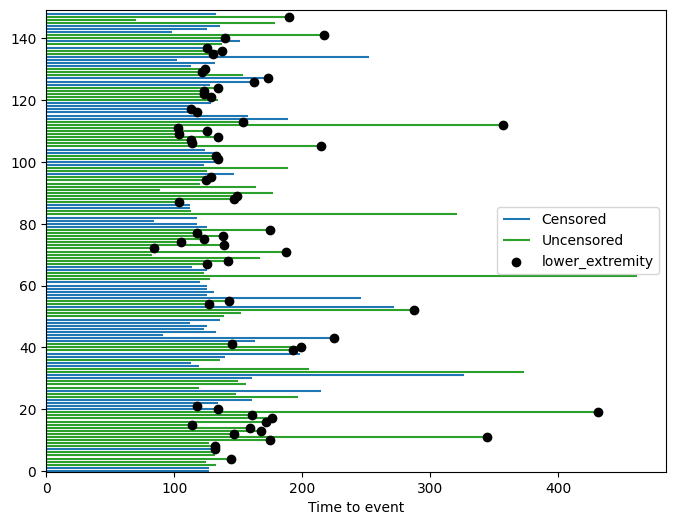

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
blue, _, red = sns.color_palette()[:3]
ax.hlines(patients[df.event.values == 0], 0, df[df.event.values == 0].time,
          color=blue, label='Censored')
ax.hlines(patients[df.event.values == 1], 0, df[df.event.values == 1].time,
          color=red, label='Uncensored')
ax.scatter(df[df.ros.values == 1].time, patients[df.ros.values == 1],
           color='k', zorder=10, label='lower_extremity')
ax.set_xlim(left=0)
ax.set_xlabel('Time to event')
ax.set_ylim(-0.25, n_patients + 0.25)
ax.legend(loc='center right')

In [47]:
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)
last_period = np.array(np.floor((df.time - 0.01) / interval_length), dtype=np.int)
death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = df.event

C:\Users\au475271\AppData\Local\Temp\ipykernel_3700\3142426356.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  last_period = np.array(np.floor((df.time - 0.01) / interval_length), dtype=np.int)


In [57]:
exposure = np.greater_equal.outer(np.array(df.time), interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = df.time - interval_bounds[last_period]

In [61]:
with pm.Model() as model:
    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)
    
    sigma = pm.Uniform('sigma', 0., 10.)
    tau = pm.Deterministic('tau', sigma**-2)
    mu_beta = pm.Normal('mu_beta', 0., 10**-2)
    beta = pm.Normal('beta', mu_beta, tau)
    
    lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta * df.ros), lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)
    
    obs = pm.Poisson('obs', mu, observed=death)

c:\Users\au475271\Miniconda3\envs\py39-als\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\au475271\Miniconda3\envs\py39-als\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


In [69]:
n_samples = 100
burn = 10
thin = 20
with model:
    step = pm.Metropolis(tune_interval=1000)
    trace_ = pm.sample(n_samples, step, cores=1, chains=1, tune=0, random_seed=0)

Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [beta]
>Metropolis: [mu_beta]
>Metropolis: [sigma]
>Metropolis: [lambda0]


Sampling 1 chain for 0 tune and 35 draw iterations (0 + 35 draws total) took 438 seconds.
c:\Users\au475271\Miniconda3\envs\py39-als\lib\site-packages\arviz\data\base.py:220: UserWarning: More chains (35) than draws (4). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


KeyboardInterrupt: 